In [1]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pyclifford as pc
from numba import njit

from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import sys
sys.path.insert(0, 'clifford')

import time
import os
from multiprocess import Pool
num_cpus = len(os.sched_getaffinity(0))
print("Using {} CPUs.".format(num_cpus))

Using 4 CPUs.


# Lib
Copied from `MIPT.py` to allow for more flexible development.

In [3]:
@njit
def qubit_pos(i, D = 1):
    """Generates a list of qubit positions corresponding to qudit i.

    Args:
        i (int): The qudit position.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        list: The list of qubit positions.
    """
    return [i * D + j for j in range(D)]

def random_clifford(circ, even = True, D = 1):
    """Adds a layer of random Clifford gates to the circuit.

    Args:
        circ (pc.circuit.Circuit): The circuit to add gates to.
        even (bool, optional): Whether to add gates starting with even or odd qudits. Defaults to True.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        None
    """
    N = circ.N
    assert N % D == 0
    L = N // D

    for i in range(L // 2):
        if even:
            q1 = 2 * i
            q2 = q1 + 1
        else:
            q1 = 2 * i + 1
            q2 = (q1 + 1) % L
        circ.gate(*qubit_pos(q1, D), *qubit_pos(q2, D))

@njit
def generate_measurement_position(L, p, D = 1):
    """Generates a random list of positions to measure.

    Args:
        L (int): The number of qudits in the circuit.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        list: The list of qubit positions to measure.
    """
    positions = []
    for i in range(L):
        if np.random.rand()<p:
            positions.extend(qubit_pos(i, D))
    return positions

def random_measurement(circ, p, D = 1):
    """Adds a layer of random measurements to the circuit.

    Args:
        circ (pc.circuit.Circuit): The circuit to add measurements to.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        None
    """
    L = circ.N // D
    pos = generate_measurement_position(L, p, D)
    if pos: # not empty
        circ.measure(*pos)

def create_circuit(L, depth, p, D = 1):
    """Creates a random Clifford circuit with random measurements.
    
    Args:
        L (int): The number of qudits in the circuit.
        depth (int): The number of time steps in the circuit.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.circuit.Circuit: The random Clifford circuit.
    """
    N = L * D
    if p > 0:
        circ = pc.circuit.Circuit(N)
        for _ in range(depth):
            random_clifford(circ, even = True, D = D)
            random_measurement(circ, p, D)
            random_clifford(circ, even = False, D = D)
            random_measurement(circ, p, D)
    else:
        circ = pc.circuit.Circuit(N) # TODO: use tc.circuit.CliffordCircuit for greater speedup
        for _ in range(depth):
            random_clifford(circ, even = True, D = D)
            random_clifford(circ, even = False, D = D)
    return circ

def me_state(L, D = 1):
    """Creates a random maximally entangled state.

    Args:
        L (int): The number of qudits in the state.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.stabilizer.StabilizerState: The maximally entangled state.
    """
    N = L * D
    state = pc.zero_state(N)
    circ = create_circuit(L, L // 2, 0, D)
    circ.forward(state)
    return state

def entropy(state, D = 1, A = None, log2 = False):
    """Calculates the bipartite entanglement entropy of the state.

    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the entropy of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        A (list, optional): The list of qudit positions to calculate the entropy of. Defaults to None (first half of the qudits)
        log2 (bool, optional): Whether to return the entropy in base e or base 2. Defaults to False.
        
    Returns:
        float: The bipartite entanglement entropy.
    """
    N = state.N
    L = N // D
    if A is None:
        A = [i for i in range(L // 2)]
    entropy_log2 = state.entropy([j for i in A for j in qubit_pos(i, D)])
    if log2:
        return entropy_log2
    else:
        return entropy_log2 * np.log(2)

def bip_info(state, D = 1, recip_size = 8):
    """Calculates the bipartite mutual information of two opposite subsystems.

    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the mutual information of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        recip_size (int, optional): The reciprocal size of the subsystems, in terms of L. Defaults to 8.
    
    Returns:
        float: The bipartite mutual information.
    """
    N = state.N
    L = N // D
    assert recip_size > 2
    subsys_size = L // recip_size
    subsys_1 = [i for i in range(subsys_size)]
    subsys_2 = [L // 2 + i for i in range(subsys_size)]
    return entropy(state, D, subsys_1) + entropy(state, D, subsys_2) - entropy(state, D, subsys_1 + subsys_2)

def trip_info(state, D = 1, recip_size = 4):
    """Calculates the negative tripartite mutual information of three adjacent subsystems.
    
    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the mutual information of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        recip_size (int, optional): The reciprocal size of the subsystems, in terms of L. Defaults to 4.
    
    Returns:
        float: The negative tripartite mutual information.
    """
    N = state.N
    L = N // D
    assert recip_size > 3

    subsys_size = int(L / recip_size)
    subsys_1 = [i for i in range(subsys_size)]
    subsys_2 = [i + subsys_size for i in range(subsys_size)]
    subsys_3 = [i + 2 * subsys_size for i in range(subsys_size)]

    info_1 = entropy(state, D, subsys_1) + entropy(state, D, subsys_2) + entropy(state, D, subsys_3)
    info_2 = entropy(state, D, subsys_1 + subsys_2) + entropy(state, D, subsys_2 + subsys_3) + entropy(state, D, subsys_3 + subsys_1)
    info_3 = entropy(state, D, subsys_1 + subsys_2 + subsys_3)
    return -info_1 + info_2 - info_3

def sample(f, L, p, D = 1, timesteps = 128, depth = None):
    """
    Samples a function f from a stabilizer state.

    Args:
        f (function): The function to sample. Takes a pc.stabilizer.StabilizerState as input and returns a numpy.ndarray.
        L (int): The number of qudits in the state.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        timesteps (int, optional): The number of timesteps to sample for. Defaults to 128.
        depth (int, optional): The initial depth of the circuit. Defaults to None (L // 2).
    Returns:
        numpy.ndarray: An array with two columns containing the mean of f and f^2 over the samples.
    """
    N = L * D
    state = pc.zero_state(N)
    accumulator = np.zeros_like(f(state))
    accumulator_sq = np.zeros_like(accumulator)

    if depth is None:
        depth = L // 2
    circ = create_circuit(L, depth, p, D)
    circ.forward(state)
    parity = True

    for _ in range(timesteps):
        result = f(state)
        accumulator += result
        accumulator_sq += result ** 2
        circ = pc.circuit.Circuit(N)
        if parity:
            random_clifford(circ, even = True, D = D)
        else:
            random_clifford(circ, even = False, D = D)
        if p > 0:
            random_measurement(circ, p, D)
        circ.forward(state)
        parity = not parity
    
    accumulator /= timesteps
    accumulator_sq /= timesteps

    return np.stack((accumulator, accumulator_sq))

@njit
def xi(L, z1, z2):
    """Calculates xi, as defined by Li et al. in https://arxiv.org/abs/2003.12721.

    Args:
        L (int): The number of qudits in the state.
        z1 (int): The first qudit position.
        z2 (int): The second qudit position.

    Returns:
        float: xi.
    """
    if z1 == z2:
        raise ValueError("z1 and z2 must be different")
    return (np.pi / L / np.sin(np.pi * (z1 - z2) / L)) ** 2


# Dev

In [8]:
D = 3
L = 256
depth = L // 2
shots = 64
timesteps = 128
N = L * D

TIMELIMIT = 60 * 60 * 0.5 # 30 minutes
MAXRUNS = 16

p_dict = {
    1: 0.16,
    2: 0.33,
    3: 0.418,
    4: 0.458,
    5: 0.478
}
p = p_dict[D]

In [10]:
def f(state):
    result = []
    qudits = [0]
    for i in range(1, L // 2 + 1):
        qudits.append(i)
        result.append(entropy(state, D, qudits))
    return np.array(result)

In [74]:
state = pc.zero_state(512)
circ = create_circuit(512, 256, 0.2, 1)
circ.forward(state)
starttime = time.time()
m = pc.stabilizer.random_clifford_map(512)
middletime = time.time()
print("Generating gate done in {}".format(middletime - starttime))
state.transform_by(m)
print("Transforming state done in {}".format(time.time() - middletime))

Generating gate done in 0.42130541801452637
Transforming state done in 0.02018427848815918


In [75]:
state.measure(pc.paulialg.paulis([pc.paulialg.pauli({i:'Z'},512) for i in [2,6,15,23,76,123,456]]))

(array([1, 0, 0, 0, 1, 1, 0]), -7.0)

In [76]:
starttime = time.time()
state.transform_by(m)
print(time.time()-starttime)

0.6313769817352295


In [16]:
circ = create_circuit(L, depth, p, D)

In [17]:
state = pc.zero_state(N)
circ.forward(state)

StabilizerState(
   -IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIYZYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
   -IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [18]:
f(state)

array([2.07944154, 2.07944154, 2.07944154, 2.07944154, 2.07944154,
       2.07944154, 2.07944154, 2.07944154, 3.4657359 , 2.77258872,
       2.77258872, 2.77258872, 4.85203026, 4.85203026, 4.85203026,
       4.85203026, 4.85203026, 3.4657359 , 3.4657359 , 3.4657359 ,
       5.54517744, 5.54517744, 5.54517744, 5.54517744, 5.54517744,
       4.15888308, 4.15888308, 4.15888308, 5.54517744, 5.54517744,
       5.54517744, 4.85203026, 4.85203026, 4.85203026, 4.85203026,
       4.85203026, 4.85203026, 4.15888308, 4.15888308, 4.15888308,
       6.23832463, 4.85203026, 4.85203026, 6.23832463, 8.31776617,
       6.23832463, 6.23832463, 6.23832463, 6.23832463, 5.54517744,
       7.62461899, 6.93147181, 6.93147181, 4.85203026, 4.85203026,
       4.85203026, 6.23832463, 4.85203026, 4.85203026, 4.15888308,
       4.15888308, 4.15888308, 4.15888308, 4.15888308, 4.15888308,
       4.15888308, 5.54517744, 4.15888308, 4.15888308, 3.4657359 ,
       4.85203026, 3.4657359 , 5.54517744, 5.54517744, 5.54517

In [50]:
run = 0
accumulator = np.zeros((2, L // 2))

start_time = time.time()

while time.time() - start_time < TIMELIMIT and run < MAXRUNS:
    with Pool(num_cpus) as pool:
        results = pool.starmap(lambda: sample(f, L, p, D, timesteps, depth), [[]] * shots)
    results = np.mean(np.array(results), axis = 0)
    accumulator += results
    run += 1
accumulator /= run

In [51]:
mean = accumulator[0, :]
std = np.sqrt(accumulator[1, :] - mean**2) / np.sqrt(run * shots * timesteps)

result = np.stack((mean, std))
result

array([[8.27385218e-01, 1.12655455e+00, 1.36440083e+00, 1.56990390e+00,
        1.74377241e+00, 1.89739204e+00, 2.03519439e+00, 2.15946400e+00,
        2.27051287e+00, 2.37119668e+00, 2.46109767e+00, 2.54574209e+00,
        2.62204688e+00, 2.69332249e+00, 2.75854830e+00, 2.81825842e+00,
        2.87566285e+00, 2.93235335e+00, 2.98458582e+00, 3.03448087e+00,
        3.08125054e+00, 3.12742263e+00, 3.17083423e+00, 3.21256415e+00,
        3.25609209e+00, 3.29276641e+00, 3.32919746e+00, 3.36681838e+00,
        3.40353500e+00, 3.43836898e+00, 3.47255251e+00, 3.50547214e+00,
        3.53850282e+00, 3.57031190e+00, 3.59838216e+00, 3.62446931e+00,
        3.65074156e+00, 3.67774358e+00, 3.70279423e+00, 3.72755930e+00,
        3.74737983e+00, 3.76766043e+00, 3.78897225e+00, 3.81202921e+00,
        3.83280163e+00, 3.85575811e+00, 3.87695359e+00, 3.89780533e+00,
        3.91835035e+00, 3.94105828e+00, 3.96331671e+00, 3.98363433e+00,
        4.00453895e+00, 4.02304798e+00, 4.03925131e+00, 4.056491

In [64]:
x = np.array([xi(L, 0, i) for i in range(1, L // 2 + 1)])
def f(xi, h, c):
    return -h*np.log(xi)+c
start = x.shape[0] // 8
end = 7 * x.shape[0] // 8
fit_result = curve_fit(f, x[start:end], result[0, start:end], p0 = [0.5, 1], sigma = result[1, start:end])
h = fit_result[0][0]
c = fit_result[0][1]

In [65]:
def fit(start):
    fit_result = curve_fit(f, x[start:end], result[0, start:end], p0 = [0.5, 1], sigma = result[1, start:end])
    return fit_result[0][0]

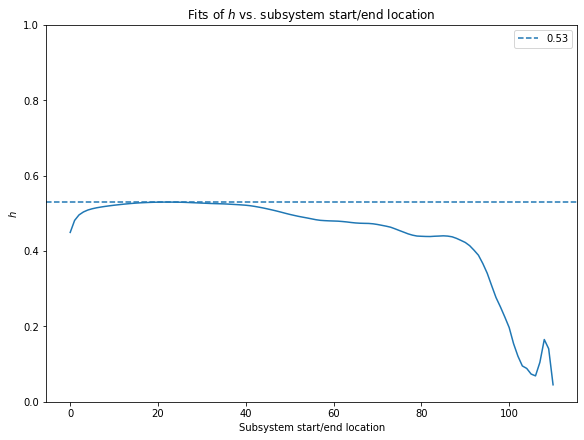

In [66]:
hs = []
for i in range(7 * L // 16 - 1):
    hs.append(fit(i))
hs = np.array(hs)
plt.subplots(figsize = (8, 6), layout = "constrained")
plt.plot(range(7 * L // 16 - 1), hs)
plt.ylim(0, 1)
plt.xlabel("Subsystem start/end location")
plt.ylabel("$h$")
plt.title("Fits of $h$ vs. subsystem start/end location")
plt.axhline(0.53, linestyle = "--", label = "0.53")
plt.legend()

Text(0.5, 1.0, 'Entanglement entropy as $\\tau\\to\\infty$, mapped to 2-point function, $L=256$, $M=1$')

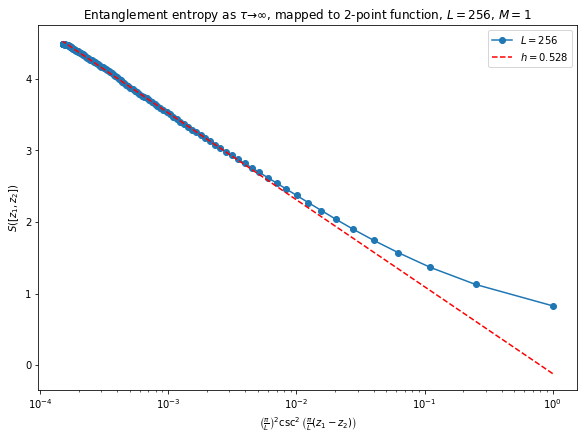

In [67]:
plt.subplots(figsize = (8, 6), layout = "constrained")
plt.plot(x, result[0, :], marker = "o", label = "$L={}$".format(L))
plt.plot(x, f(x, h, c), linestyle = "--", color = "red", label = "$h={:.3f}$".format(h))
plt.fill_between(x, result[0, :] - result[1, :], result[0, :] + result[1, :], alpha = 0.5)
plt.xscale('log')
plt.ylabel(r"$S([z_1,z_2])$")
plt.xlabel(r"$\left(\frac{\pi}{L}\right)^2\csc^2\left(\frac{\pi}{L}(z_1-z_2)\right)$")
plt.legend()
plt.title("Entanglement entropy as $\\tau\\to\infty$, mapped to 2-point function, $L={}$, $M={}$".format(L, D))

Text(0.5, 1.0, 'Entanglement entropy as $\\tau\\to\\infty$, mapped to 2-point function, $L=256$, $M=1$')

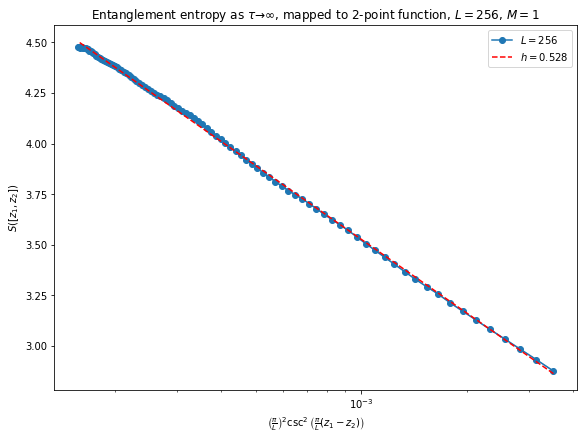

In [69]:
plt.subplots(figsize = (8, 6), layout = "constrained")
plt.plot(x[start:end], result[0, start:end], marker = "o", label = "$L={}$".format(L))
plt.plot(x[start:end], f(x, h, c)[start:end], linestyle = "--", color = "red", label = "$h={:.3f}$".format(h))
plt.fill_between(x[start:end], result[0, start:end] - result[1, start:end], result[0, start:end] + result[1, start:end], alpha = 0.5)
plt.xscale('log')
plt.ylabel(r"$S([z_1,z_2])$")
plt.xlabel(r"$\left(\frac{\pi}{L}\right)^2\csc^2\left(\frac{\pi}{L}(z_1-z_2)\right)$")
plt.legend()
plt.title("Entanglement entropy as $\\tau\\to\infty$, mapped to 2-point function, $L={}$, $M={}$".format(L, D))